# Ionospheric Connection Explorer (ICON) on Jupyter Notebook v2.0

<img src="https://drive.google.com/uc?id=1smTGLEQl2fu84PE8PQroytadcd5cT0SG"> 


- Access all data products and data documents on the website: <https://icon.ssl.berkeley.edu/Data>
- <p><a href="https://icon.ssl.berkeley.edu/Portals/devIcon/Data/Rules_of_The_Road_ICON_v0.2.pdf?ver=2018-05-07-141215-957" target="_blank">ICON Rules of the Road</a> - Please review the RotR for the ICON products, and consult with instrument&nbsp;scientists to support your analyses.</p>
- <p><a href="ftp://icon-science.ssl.berkeley.edu/pub" target="_blank">ICON Public Data</a> - All ICON Data Products are available in NetCDF formats at this FTP site.</p>


LEVEL.2 Data products: 
- L2.1 MIGHTI -- Line-of-Sight Winds 
- L2.2 MIGHTI -- Neutral Vector Winds -- Zonal Wind, Meridional Wind, Field-aligned Wind 
- L2.3 MIGHTI-A/B* -- Neutral Temperature
- L2.4 FUV--Column O/$N_{2}$
- L2.5 FUV--Nighttime $O^{+}$ Density, NmF2, HmF2
- L2.6 EUV--Daytime $O^{+}$ Density, NmF2, HmF2
- L2.7 IVM-A/B* -- Ion Drift, Ion Densities, Ion Temperature 
- A/B* are two identical instruments pointing to different directions.

### Note: 
- IDL version:
> <p><a href=" https://github.com/YJWu-SSL/ICON_Data_Demo/blob/master/ICON_IDL_EUVIVM_Tutorial.pro" target="_blank">ICON_IDL_EUVIVM_Tutorial.pro</a>
> <p><a href=" https://github.com/YJWu-SSL/ICON_Data_Demo/blob/master/ICON_IDL_MIGHTIIVM_Tutorial.pro" target="_blank">ICON_IDL_MIGHTIIVM_Tutorial.pro</a>
> <p><a href=" https://github.com/YJWu-SSL/ICON_Data_Demo/blob/master/ICON_IDL_MIGHTI_Tutorial.pro" target="_blank">ICON_IDL_MIGHTI_Tutorial.pro</a>
- Please read variable notes and quality flags for caveats, limitations, and best practices.
- Please check official data sources for the latest version of the data.
- Any questions? yjwu@dn {dn=ssl.berkeley.edu}



# 1. Get Ready

### Import Python packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from datetime import datetime, timedelta
import bisect
import netCDF4
import pandas as pd
import seaborn as sns
import pylab
import os
import glob
from ftplib import FTP
import fnmatch
import matplotlib.dates as mdates

'''Optional: Specify the plotting style '''
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 15,\
                     'xtick.labelsize' : 15,\
                     'ytick.labelsize' : 15,\
                     'axes.titlesize' : 16,\
                     'axes.labelsize' : 16,\
                     'date.autoformatter.minute': '%H:%M' })

### Additional functions

In [2]:
def download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product, ICON_instrument, ICON_level='LEVEL.2',MTAB=None):
    '''
    INPUTS
    ------

      ftp        class : ftp class that has logged in to the ftp site ftp=libftp.ftp('address')
      target_YYYY        str : the year of the target day 
      target_doy         str : the day of year of the target day
      ICON_product       str : i.e. 'L2.1','L2.2','L2.3','L2.4','L2.5','L2.6','L2.7'
      ICON_instrument    str : has to be one of the following ['MIGHTI','IVM-A','FUV','EUV']

      Optional:
        ICON_level       str : 'LEVEL.2','LEVEL.1'
        MTAB             str : A required input when retrieving L2.3 MIGHTI Temperature, MTAB='A' for MIGHTI-A, MTAB='B' for MIGHTI-B 

    RESULT
    -------
      Download (retrieve) the latest version of ICON data from the FTP site hosting at UC Berkeley (https://icon.ssl.berkeley.edu/Data)

  '''

    target_dir='/pub/%s/%s/%s/%s' % (ICON_level, ICON_instrument,target_YYYY,target_doy)

    if target_dir in ftp.nlst('/pub/%s/%s/%s/' % (ICON_level, ICON_instrument,target_YYYY)):
        ftp.cwd(target_dir+'/ZIP/')
        filenames=ftp.nlst()
        if not (ICON_product == 'L2-3'):
            if ftp.nlst("ICON_%s*" % (ICON_product)):
                select_fn=sorted(ftp.nlst("ICON_%s*" % (ICON_product)), key=lambda x: ftp.voidcmd(f"MDTM {x}"))[-1]
            else:
                raise Exception('File does not exist!')
        else:
            if (MTAB == None):
                raise Exception('Please specify MIGHTI-A or -B in keyword MTAB, MTAB="A" for example ')
            else:
                if ftp.nlst('ICON_%s_%s-%s*' % (ICON_product, ICON_instrument,MTAB)):
                    select_fn=sorted(ftp.nlst('ICON_%s_%s-%s*' % (ICON_product, ICON_instrument,MTAB)), key=lambda x: ftp.voidcmd(f"MDTM {x}"))[-1]
                else:
                    raise Exception('File does not exist!')
        download_file = open(select_fn, 'wb')
        ftp.retrbinary('RETR '+ select_fn, download_file.write)

        download_file.close()
        print('%s has been retrieved' % select_fn)
    else:
        raise Exception('/pub/%s/%s/%s/%s/ZIP/ does not exist!' % (ICON_level, ICON_instrument,target_YYYY,target_doy))
    
    return

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    '''
  Math text formatter on colorbars
  source:
  https://stackoverflow.com/questions/42656139/set-scientific-notation-with-fixed-exponent-and-significant-digits-for-multiple
    '''
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# 2. Download ICON data from the FTP site

In [3]:
'''Insert a target day'''
target_datetime=datetime(2020,3,24) # (year, month, day)
target_YYYY='%4i' % target_datetime.year
target_mm='%02i' % target_datetime.month
target_dd='%02i' % target_datetime.day
target_doy='%03i' % ((target_datetime-datetime(np.int(target_YYYY),1,1)).days+1)
target_date_str='%s-%s-%s' % (target_YYYY,target_mm,target_dd)

if not glob.glob('ICON*%s*' % target_date_str):

    ftp=FTP('icon-science.ssl.berkeley.edu')

    ftp.login()
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-2', ICON_instrument='MIGHTI')
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-3', ICON_instrument='MIGHTI',MTAB='A')
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-4', ICON_instrument='FUV')
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-5', ICON_instrument='FUV')
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-6', ICON_instrument='EUV')
    download_ICON_ftp(ftp, target_YYYY, target_doy, ICON_product='L2-7', ICON_instrument='IVM-A')
    # 
    ftp.quit()

<ipython-input-3-a5c477041b03>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target_doy='%03i' % ((target_datetime-datetime(np.int(target_YYYY),1,1)).days+1)


ICON_L2-2_MIGHTI_2020-03-24_v04r001.ZIP has been retrieved
ICON_L2-3_MIGHTI-A_Temperature_2020-03-24_v04r000.ZIP has been retrieved
ICON_L2-4_FUV_Day_2020-03-24_v04r000.ZIP has been retrieved
ICON_L2-5_FUV_Night_2020-03-24_v04r000.ZIP has been retrieved
ICON_L2-6_EUV_2020-03-24_v02r002.ZIP has been retrieved
ICON_L2-7_IVM-A_2020-03-24_v05r000.ZIP has been retrieved


In [4]:
'''Unzip the file'''
!unzip '*.ZIP'

Archive:  ICON_L2-2_MIGHTI_2020-03-24_v04r001.ZIP
ICON archive of file set ICON_L2-2_MIGHTI_2020-03-24.
  inflating: 084/ICON_L2-2_MIGHTI_Vector-Wind-Green_2020-03-24_v04r001.NC  
  inflating: 084/ICON_L2-2_MIGHTI_Vector-Wind-Red_2020-03-24_v04r001.NC  

Archive:  ICON_L2-3_MIGHTI-A_Temperature_2020-03-24_v04r000.ZIP
ICON archive of file set ICON_L2-3_MIGHTI-A_Temperature_2020-03-24.
  inflating: 084/ICON_L2-3_MIGHTI-A_Temperature_2020-03-24_v04r000.NC  

Archive:  ICON_L2-4_FUV_Day_2020-03-24_v04r000.ZIP
ICON archive of file set ICON_L2-4_FUV_Day_2020-03-24.
  inflating: 084/ICON_L2-4_FUV_Day_2020-03-24_v04r000.NC  

Archive:  ICON_L2-5_FUV_Night_2020-03-24_v04r000.ZIP
ICON archive of file set ICON_L2-5_FUV_Night_2020-03-24.
  inflating: 084/ICON_L2-5_FUV_Night_2020-03-24_v04r000.NC  

Archive:  ICON_L2-6_EUV_2020-03-24_v02r002.ZIP
ICON archive of file set ICON_L2-6_EUV_2020-03-24.
  inflating: 084/ICON_L2-6_EUV_2020-03-24_v02r002.NC  

Archive:  ICON_L2-7_IVM-A_2020-03-24_v05r000.ZIP

# 3. Read ICON netCDF files

In [5]:
'''
Alternative way to deal with netCDF file other than dict is xarray
http://xarray.pydata.org/en/stable/io.html
'''
# import xarray as xr
# with xr.open_dataset(fn_L27) as ds:
#     print(ds.keys())

'\nAlternative way to deal with netCDF file other than dict is xarray\nhttp://xarray.pydata.org/en/stable/io.html\n'

In [6]:
'''MIGHTI L2.2 Vector Wind'''
MT_color= 'Green'
fn_L22=glob.glob('%s/ICON_L2-2_*%s*.NC' % (target_doy,MT_color))[0]
## Load winds
dm_g = {}
with netCDF4.Dataset(fn_L22) as d:
    time_msec  = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dm_g['time_ms'] = time_msec
    dm_g['time'] = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dm_g['orb_num']  = np.ma.filled(d.variables['ICON_L22_Orbit_Number'][...], np.nan)

    dm_g['uzon'] = np.ma.filled(d.variables['ICON_L22_Zonal_Wind'][...], np.nan) #>0: Eastward, <0: Westward
    dm_g['umer'] = np.ma.filled(d.variables['ICON_L22_Meridional_Wind'][...], np.nan) #>0: northward, <0: southward
    dm_g['tang_alt']  = np.ma.filled(d.variables['ICON_L22_Altitude'][...], np.nan)
    dm_g['tang_lon']  = np.ma.filled(d.variables['ICON_L22_Longitude'][...], np.nan)
    dm_g['tang_lat']  = np.ma.filled(d.variables['ICON_L22_Latitude'][...], np.nan)
    dm_g['tang_slt']  = np.ma.filled(d.variables['ICON_L22_Local_Solar_Time'][...], np.nan)
    
    # Simple quality control
    wind_quality = np.ma.filled(d.variables['ICON_L22_Wind_Quality'][...], np.nan)
    good_data = (wind_quality == 1)| (wind_quality == 0.5)
    dm_g['uzon'][~good_data] = np.nan
    dm_g['umer'][~good_data] = np.nan


print('Orbit numbers: %04i to %04i' % (np.nanmin(dm_g['orb_num']),np.nanmax(dm_g['orb_num'])))

Orbit numbers: 2466 to 2481


In [7]:
'''MIGHTI L2.2 Vector Wind'''
MT_color= 'Red'
fn_L22=glob.glob('%s/ICON_L2-2_*%s*.NC' % (target_doy,MT_color))[0]
### Load winds
dm_r = {}
with netCDF4.Dataset(fn_L22) as d:
    time_msec  = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dm_r['time_ms'] = time_msec
    dm_r['time'] = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dm_r['orb_num']  = np.ma.filled(d.variables['ICON_L22_Orbit_Number'][...], np.nan)

    dm_r['uzon'] = np.ma.filled(d.variables['ICON_L22_Zonal_Wind'][...], np.nan) #>0: Eastward, <0: Westward
    dm_r['umer'] = np.ma.filled(d.variables['ICON_L22_Meridional_Wind'][...], np.nan) #>0: northward, <0: southward
    dm_r['tang_alt']  = np.ma.filled(d.variables['ICON_L22_Altitude'][...], np.nan)
    dm_r['tang_lon']  = np.ma.filled(d.variables['ICON_L22_Longitude'][...], np.nan)
    dm_r['tang_lat']  = np.ma.filled(d.variables['ICON_L22_Latitude'][...], np.nan)
    dm_r['tang_slt']  = np.ma.filled(d.variables['ICON_L22_Local_Solar_Time'][...], np.nan)
    
    # Simple quality control
    wind_quality = np.ma.filled(d.variables['ICON_L22_Wind_Quality'][...], np.nan)
    good_data = (wind_quality == 1)| (wind_quality == 0.5)
    dm_r['uzon'][~good_data] = np.nan
    dm_r['umer'][~good_data] = np.nan


print('Orbit numbers: %04i to %04i' % (np.nanmin(dm_r['orb_num']),np.nanmax(dm_r['orb_num'])))

Orbit numbers: 2466 to 2481


In [8]:
'''MIGHTI L2.3 Temperature'''
MTAB='A'

fn_L23=glob.glob('%s/ICON_L2-3_MIGHTI-%s*.NC' % (target_doy, MTAB))[0]

#### Load Temperature ###
dTN = {}
with netCDF4.Dataset(fn_L23) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dTN['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dTN['TN']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Temperature' % (MTAB)][...], np.nan) 
    dTN['mlat']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Magnetic_Longitude' % (MTAB)][...], np.nan) 
    dTN['tang_slt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Local_Solar_Time' % (MTAB)][...], np.nan) 
    dTN['tang_alt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Altitude' % (MTAB)][...], np.nan) 
    dTN['tang_lat']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Latitude' % (MTAB)][...], np.nan) 
    dTN['tang_lon']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Longitude' % (MTAB)][...], np.nan) 

    dTN['SC_lat']   = np.ma.filled(d.variables['ICON_L23_Observatory_Latitude'][...], np.nan) 
    dTN['SC_lon']   = np.ma.filled(d.variables['ICON_L23_Observatory_Longitude'][...], np.nan) 

    dTN['orb_num'] = np.ma.filled(d.variables['ICON_L23_Orbit_Number'][...], np.nan)

    # Simple quality control
    saa_flag  = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_South_Atlantic_Anomaly' % (MTAB)][...], np.nan) # SAA flag
    cali_flag = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_Bad_Calibration' % (MTAB)][...], np.nan) # Calibration flag

    good_data = (dTN['TN'] > 0)
    dTN['TN'][~good_data] = np.nan
    good_data = (saa_flag == 0) & (cali_flag == 0)# 
    dTN['TN'][:,~good_data] = np.nan # only good data are shown

print('Orbit number: %04i to %04i' % (np.nanmin(dTN['orb_num']),np.nanmax(dTN['orb_num'])))

Orbit number: 2466 to 2481


In [9]:
'''FUV L2.4 Disk O/N2'''
fn_L24 =glob.glob('%s/ICON_L2-4_FUV*.NC' % (target_doy))[0]

#  Load L2.4 disk O/N2 #
dON2 = {}
with netCDF4.Dataset(fn_L24) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dON2['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dON2['disk_ON2']  = np.ma.filled(d.variables['ICON_L24_Disk_ON2'][...], np.nan) 
    dON2['disk_slt']   = np.ma.filled(d.variables['ICON_L24_Local_Solar_Time_Disk'][...], np.nan)
    dON2['disk_lon']   = np.ma.filled(d.variables['ICON_L24_Disk_Longitude'][...], np.nan) 
    dON2['disk_lat']   = np.ma.filled(d.variables['ICON_L24_Disk_Latitude'][...], np.nan) 
    dON2['disk_mlon']   = np.ma.filled(d.variables['ICON_L24_Disk_Magnetic_Longitude'][...], np.nan) 
    dON2['disk_mlat']   = np.ma.filled(d.variables['ICON_L24_Disk_Magnetic_Latitude'][...], np.nan)  
    dON2['SC_lon']   = np.ma.filled(d.variables['ICON_L24_Observatory_Longitude'][...], np.nan)
    dON2['SC_lat']   = np.ma.filled(d.variables['ICON_L24_Observatory_Latitude'][...], np.nan)
    # dON2['orb_num']   = np.ma.filled(d.variables['ICON_L24_Orbit_Number'][...], np.nan)  

    # Simple quality control
    model_flag  = np.ma.filled(d.variables['ICON_L24_Disk_Retrieval_Flags'][...], np.nan) 
    good_data = ( model_flag == 0) 
    dON2['disk_ON2'][~good_data] = np.nan

print( (np.nanmin(dON2['time']),np.nanmax(dON2['time'])))

    


(datetime.datetime(2020, 3, 24, 0, 0, 11, 519000), datetime.datetime(2020, 3, 24, 23, 59, 52, 601000))


In [10]:
'''FUV L2.5 Nighttime Ionosphere'''
fn_L25 =glob.glob('%s/ICON_L2-5_FUV*.NC' % (target_doy))[0]

# Load L2.6 Daytime plasma observations #
dL25 = {}
with netCDF4.Dataset(fn_L25) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dL25['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dL25['HmF2']  = np.ma.filled(d.variables['ICON_L25_HMF2'][...], np.nan) 
    dL25['NmF2']  = np.ma.filled(d.variables['ICON_L25_NMF2'][...], np.nan) 
    dL25['O_plus']  = np.ma.filled(d.variables['ICON_L25_O_Plus_Density'][...], np.nan)
    dL25['orb_num']  = np.ma.filled(d.variables['ICON_L25_Orbit_Number'][...], np.nan) 

    dL25['tang_slt']   = np.ma.filled(d.variables['ICON_L25_Local_Solar_Time'][...], np.nan) 
    dL25['HmF2_lon']   = np.ma.filled(d.variables['ICON_L25_Longitude'][...], np.nan) 
    dL25['HmF2_lat']   = np.ma.filled(d.variables['ICON_L25_Latitude'][...], np.nan) 

    dL25['HmF2_mlon']   = np.ma.filled(d.variables['ICON_L25_Magnetic_Longitude'][...], np.nan) 
    dL25['HmF2_mlat']   = np.ma.filled(d.variables['ICON_L25_Magnetic_Latitude'][...], np.nan) 

    # Simple quality control
    L25_flag  = np.ma.filled(d.variables['ICON_L25_Quality'][...], np.nan) 
    good_data = ( L25_flag == 1)# Allow L26_flag=0 and 1. 0 =No issues reported, 1 = Moderate issue(s) identified, use results with caution, 2 = Severe issue(s) identified.,
    dL25['HmF2'][~good_data] = np.nan
    dL25['NmF2'][~good_data] = np.nan
    dL25['HmF2_mlon'][~good_data] = np.nan
    dL25['HmF2_mlat'][~good_data] = np.nan
    # dL25['Oplus'][~good_data,:] = np.nan

    
print('Orbit number: %04i to %04i' % (np.nanmin(dL25['orb_num']),np.nanmax(dL25['orb_num'])))

Orbit number: 2466 to 2481


In [11]:
'''EUV L2.6 Daytime Ionosphere'''
fn_L26 =glob.glob('%s/ICON_L2-6_EUV*.NC' % (target_doy))[0]

# Load L2.6 Daytime plasma observations #
dEUV = {}
with netCDF4.Dataset(fn_L26) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dEUV['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dEUV['HmF2']  = np.ma.filled(d.variables['ICON_L26_HmF2'][...], np.nan) 
    dEUV['NmF2']  = np.ma.filled(d.variables['ICON_L26_NmF2'][...], np.nan) 
    dEUV['Oplus']  = np.ma.filled(d.variables['ICON_L26_Oplus'][...], np.nan)
    dEUV['orb_num']  = np.ma.filled(d.variables['ICON_L26_Orbit_Number'][...], np.nan) 

    dEUV['tang_slt']   = np.ma.filled(d.variables['ICON_L26_Local_Solar_Time'][...], np.nan) 
    dEUV['tang_lon']   = np.ma.filled(d.variables['ICON_L26_Longitude'][...], np.nan) 
    dEUV['tang_lat']   = np.ma.filled(d.variables['ICON_L26_Latitude'][...], np.nan) 
    dEUV['tang_alt']   = np.ma.filled(d.variables['ICON_L26_Altitude'][...], np.nan) 

    dEUV['tang_mlon']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Longitude'][...], np.nan) 
    dEUV['tang_mlat']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Latitude'][...], np.nan) 

    # Simple quality control
    L26_flag  = np.ma.filled(d.variables['ICON_L26_Flag'][...], np.nan) 
    good_data = ( L26_flag == 0)|( L26_flag == 1 ) # Allow L26_flag=0 and 1. 0 =No issues reported, 1 = Moderate issue(s) identified, use results with caution, 2 = Severe issue(s) identified.,
    dEUV['HmF2'][~good_data] = np.nan
    dEUV['NmF2'][~good_data] = np.nan
    dEUV['Oplus'][~good_data,:] = np.nan

    
print('Orbit number: %04i to %04i' % (np.nanmin(dEUV['orb_num']),np.nanmax(dEUV['orb_num'])))

Orbit number: 2466 to 2480


In [12]:
'''IVM L2.7 In-situ Plasma Measurement'''
fn_L27 =glob.glob('%s/ICON_L2-7_IVM-A*.NC' % (target_doy))[0]

#### Load ion velocity
di = {}
with netCDF4.Dataset(fn_L27) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    di['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    di['vmer']  = np.ma.filled(d.variables['ICON_L27_Ion_Velocity_Meridional'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    di['Ni']  = np.ma.filled(d.variables['ICON_L27_Ion_Density'][...], np.nan) 

    di['mlat']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Latitude'][...], np.nan) 
    di['mlon']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Longitude'][...], np.nan) 
    di['slt']   = np.ma.filled(d.variables['ICON_L27_Solar_Local_Time'][...], np.nan) 
    di['alt']   = np.ma.filled(d.variables['ICON_L27_Altitude'][...], np.nan) 
    di['lon']   = np.ma.filled(d.variables['ICON_L27_Longitude'][...], np.nan) 
    di['lat']   = np.ma.filled(d.variables['ICON_L27_Latitude'][...], np.nan) 

    di['orb_num']   = np.ma.filled(d.variables['ICON_L27_Orbit_Number'][...], np.nan) # Local solar time

#     In latest released version v02r002, use the flags below
    DM_flag   = np.ma.filled(d.variables['ICON_L27_DM_Flag'][...], np.nan) # Quality control variable for Drift Meter
    RPA_flag  = np.ma.filled(d.variables['ICON_L27_RPA_Flag'][...], np.nan) # Quality control variable for RPA
    good_data = (DM_flag == 0) & (RPA_flag < 2)
    di['Ni'][~good_data] = np.nan
    di['mlat'][~good_data] = np.nan
print('Orbit number: %04i to %04i' % (np.nanmin(di['orb_num']),np.nanmax(di['orb_num'])))

Orbit number: 2466 to 2481


# Example 1: Visualizing data in a single orbit


*   This practice will demostrate the how to use *orbit number* and how to compare different ICON product.


*   Use L2.2 Vector Wind and L2.3 Temperature for demonstration.





In [13]:
# Select a particular orbit
target_orbit_num = 2470

dTN_select_orb_num_idx = np.argwhere(dTN['orb_num']== target_orbit_num)
dTN_select_idx = dTN_select_orb_num_idx[:,0]

select_dTN = {}
select_dTN['orb_num'] = dTN['orb_num'][dTN_select_idx]
select_dTN['time']    = dTN['time'][dTN_select_idx]
select_dTN['TN']      = dTN['TN'][:,dTN_select_idx]
select_dTN['tang_slt']      = dTN['tang_slt'][:,dTN_select_idx]
select_dTN['tang_lon'] = dTN['tang_lon'][:,dTN_select_idx]
select_dTN['tang_lat'] = dTN['tang_lat'][:,dTN_select_idx]
select_dTN['tang_alt'] = dTN['tang_alt'][:,dTN_select_idx]


dm_select_idx=np.where((dm_g['time']>=select_dTN['time'][0]) & (dm_g['time'] < select_dTN['time'][-1]))
select_dm_g = {}
select_dm_g['orb_num'] = dm_g['orb_num'][dm_select_idx]
select_dm_g['time']    = dm_g['time'][dm_select_idx]
select_dm_g['uzon']    = dm_g['uzon'][dm_select_idx,:][0,:,:].transpose()
select_dm_g['umer']    = dm_g['umer'][dm_select_idx,:][0,:,:].transpose()
select_dm_g['tang_slt']      = dm_g['tang_slt'][dm_select_idx,:][0,:,:].transpose()
select_dm_g['tang_lon'] = dm_g['tang_lon'][dm_select_idx,:][0,:,:].transpose()
select_dm_g['tang_lat'] = dm_g['tang_lat'][dm_select_idx,:][0,:,:].transpose()
select_dm_g['tang_alt'] = dm_g['tang_alt'][:]

dm_select_idx=np.where((dm_r['time']>=select_dTN['time'][0]) & (dm_r['time'] < select_dTN['time'][-1]))
select_dm_r = {}
select_dm_r['orb_num'] = dm_r['orb_num'][dm_select_idx]
select_dm_r['time']    = dm_r['time'][dm_select_idx]
select_dm_r['uzon']    = dm_r['uzon'][dm_select_idx,:][0,:,:].transpose()
select_dm_r['umer']    = dm_r['umer'][dm_select_idx,:][0,:,:].transpose()
select_dm_r['tang_slt']      = dm_r['tang_slt'][dm_select_idx,:][0,:,:].transpose()
select_dm_r['tang_lon'] = dm_r['tang_lon'][dm_select_idx,:][0,:,:].transpose()
select_dm_r['tang_lat'] = dm_r['tang_lat'][dm_select_idx,:][0,:,:].transpose()
select_dm_r['tang_alt'] = dm_r['tang_alt'][:]
print('Selected time: %s to %s' % (select_dTN['time'][0].strftime("%m-%d-%y %H:%M:%S"),select_dTN['time'][-1].strftime("%m-%d-%y %H:%M:%S")))


Selected time: 03-24-20 06:10:28 to 03-24-20 07:46:00


## Quick view of a single orbit L2.2 Vector Wind


*   Daytime observations of the red line (630.0 nm) emission span the altitude range of ~180 to 300 km while observations of the green line (557.7 nm) emission span the altitude range of 90 to ~190 km.  
*   Nighttime observations of the red line emission span the altitude range of ~210 to 300 km while those of the green line span 90 to ~109 km.
*   Daytime observations are provided at a 30-s cadence while nighttime observations are provided at a 60-s cadence.
*   How to deal with the overlapped altitudes? 








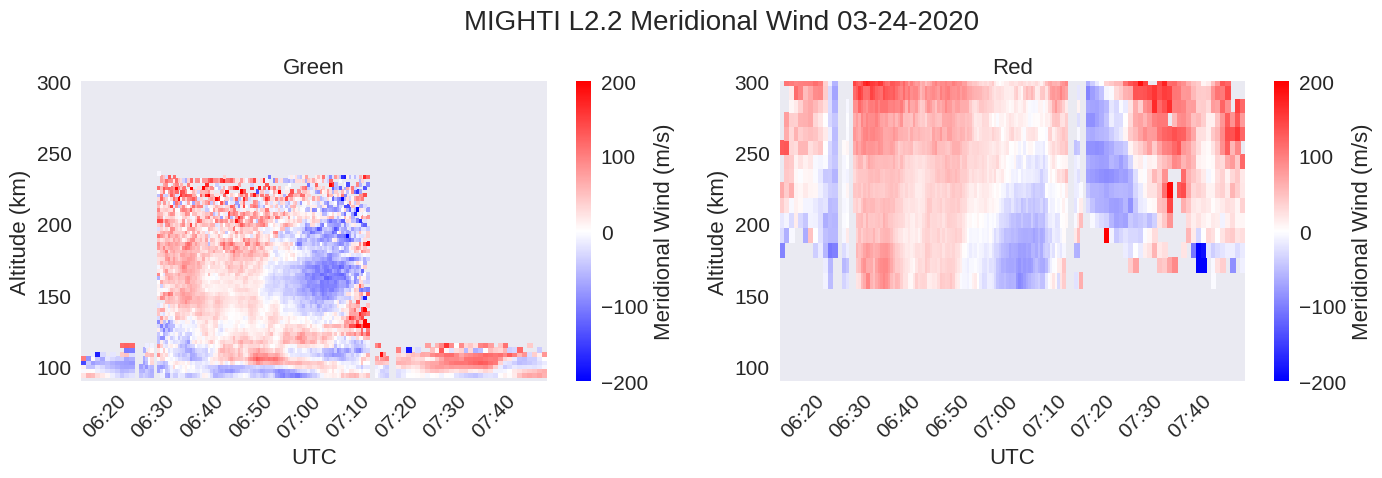

In [20]:
X_g, Y_g = np.meshgrid(select_dm_g['time'],select_dm_g['tang_alt'])
X_r, Y_r = np.meshgrid(select_dm_r['time'],select_dm_r['tang_alt'])

show_time=select_dm_g['time']

# ## Wind ###

cmap='bwr'
vmax=200
vmin=-200
variable_name='MIGHTI L2.2 Meridional Wind'
cb_label='Meridional Wind (m/s)'
xlabel='UTC'
ylabel='Altitude (km)'

plt.close()
fig,ax=plt.subplots(figsize=(16,4))
fig.suptitle('%s %s' % (variable_name, show_time[0].strftime("%m-%d-%Y")),size=20,x=0.5)
gs = gridspec.GridSpec(1,2) 

ax0=plt.subplot(gs[0,0])
im = ax0.pcolor(X_g,Y_g,select_dm_g['umer'] ,cmap=cmap,vmin=vmin,vmax=vmax, shading='auto')
ax0.set_ylim([90,300])
ax0.set_title('Green')
ax0.set_xlabel(xlabel)
ax0.set_ylabel(ylabel)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label,size=16)


ax0=plt.subplot(gs[0,1])
im = ax0.pcolor(X_r,Y_r,select_dm_r['umer'] ,cmap=cmap,vmin=vmin,vmax=vmax, shading='auto')
ax0.set_ylim([90,300])
ax0.set_title('Red')
ax0.set_xlabel(xlabel)
ax0.set_ylabel(ylabel)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label,size=16)

fig.autofmt_xdate(rotation=45)


left  = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.8     # the top of the subplots of the figure
wspace = 0.2#0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3#0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()


## Extension: Visualizing the neutral wind and temperature at mesosphere and the lower thermosphere at a time.

<ipython-input-19-cba346015df0>:40: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = ax0.pcolor(X_1_array,Y_1_array,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1, shading='auto')#,norm=colors.Normalize(vmin=0, vmax=150))


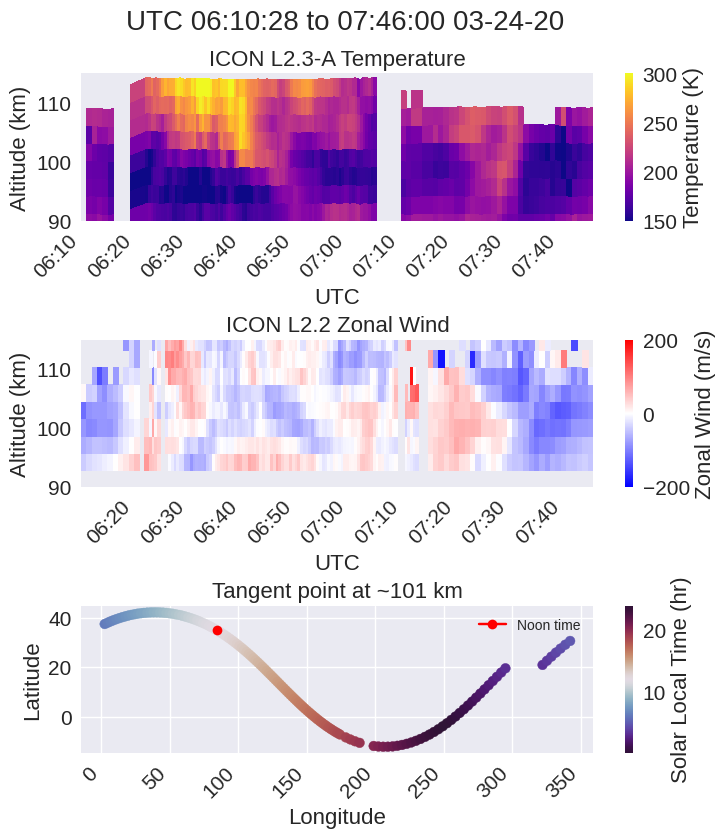

In [19]:
## Temperature ###
target_1_array=select_dTN['TN']
Y_1_array=select_dTN['tang_alt']
X_1_array, _ = np.meshgrid(select_dTN['time'],select_dTN['tang_alt'][:,0])

## Green Line Wind ###
target_2_array=select_dm_g['uzon']
X_2_array, Y_2_array = np.meshgrid(select_dm_g['time'],select_dm_g['tang_alt'])

# ## Temperature ###

cmap_1='plasma'
vmax_1=300
vmin_1=150
variable_name_1='ICON L2.3-%s Temperature' % (MTAB)
xlabel_1='UTC'
ylabel_1='Altitude (km)'
cb_label_1='Temperature (K)'
tang_alt_idx=5


# ## Wind ###

cmap_2='bwr'
vmax_2=200
vmin_2=-200
variable_name_2='ICON L2.2 Zonal Wind'
xlabel_2='UTC'
ylabel_2='Altitude (km)'
cb_label_2='Zonal Wind (m/s)'

######################## PLOT #############################
show_time=select_dTN['time']
fig,ax=plt.subplots(figsize=(8,8))#fig=pp.figure(figsize=(12,10)

fig.suptitle('UTC %s to %s' % (show_time[0].strftime("%H:%M:%S"),show_time[-1].strftime("%H:%M:%S %m-%d-%y")),size=20,x=0.43)
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 

ax0=plt.subplot(gs[0,0])
im = ax0.pcolor(X_1_array,Y_1_array,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1, shading='auto')#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.set_ylim([90,115])
ax0.set_title(variable_name_1)
ax0.set_xlabel(xlabel_1)
ax0.set_ylabel(ylabel_1)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_1)

ax0=plt.subplot(gs[1,0])
im = ax0.pcolor(X_2_array,Y_2_array,target_2_array ,cmap=cmap_2,vmin=vmin_2,vmax=vmax_2, shading='auto')#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.set_ylim([90,115])
ax0.set_title(variable_name_2)
ax0.set_xlabel(xlabel_2)
ax0.set_ylabel(ylabel_2)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_2)

ax0=plt.subplot(gs[2,0])
im=ax0.scatter(select_dTN['tang_lon'][tang_alt_idx,:],select_dTN['tang_lat'][tang_alt_idx,:],c=select_dTN['tang_slt'][tang_alt_idx,:],cmap='twilight_shifted')
ax0.set_title('Tangent point at ~%03i km' % select_dTN['tang_alt'][tang_alt_idx,1])
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')

noon_idx=np.argmin(np.abs(select_dTN['tang_slt'][tang_alt_idx,:]-12))
noon_lon=select_dTN['tang_lon'][tang_alt_idx,noon_idx]
noon_lat=select_dTN['tang_lat'][tang_alt_idx,noon_idx]
ax0.plot(noon_lon,noon_lat,marker='o',color='red',label='Noon time')
color_bar=fig.colorbar(im)
color_bar.set_label('Solar Local Time (hr)')

plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])
fig.autofmt_xdate(rotation=45)

plt.legend()

left  = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.9     # the top of the subplots of the figure
wspace = 0.1#0.2   # the amount of width reserved for blank space between subplots
hspace = 0.8#0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()


# Example 2: Ionospheric measurements by EUV, FUV and IVM
- L2.5 FUV: Remotely sensed ***nighttime*** O+ profile, HmF2 and NmF2 on the FUV's limb.
- L2.6 EUV: Remotely sensed ***daytime*** O+ profile, HmF2 and NmF2 on the EUV's limb.
- L2.7 IVM: ***In-situ*** ion density, temperature, and composition at S/C altitude (~600 km)


In [21]:

di_select_orb_num_idx = np.argwhere(di['orb_num']== target_orbit_num)
di_select_idx = di_select_orb_num_idx[:,0]

select_di = {}
select_di['orb_num'] = di['orb_num'][di_select_idx]
select_di['time']    = di['time'][di_select_idx]
select_di['Ni']      = di['Ni'][di_select_idx]
select_di['vmer']    = di['vmer'][di_select_idx]
select_di['slt']  = di['slt'][di_select_idx]
select_di['lon']  = di['lon'][di_select_idx]
select_di['lat']  = di['lat'][di_select_idx]
select_di['mlon'] = di['mlon'][di_select_idx]
select_di['mlat'] = di['mlat'][di_select_idx]


dEUV_select_idx=np.where((dEUV['time']>=select_di['time'][0]) & (dEUV['time'] < select_di['time'][-1]))
select_dEUV = {}
select_dEUV['orb_num'] = dEUV['orb_num'][dEUV_select_idx]
select_dEUV['time']    = dEUV['time'][dEUV_select_idx]
select_dEUV['Oplus']   = dEUV['Oplus'][dEUV_select_idx,:][0,:,:].transpose()
select_dEUV['HmF2']    = dEUV['HmF2'][dEUV_select_idx]
select_dEUV['NmF2']    = dEUV['NmF2'][dEUV_select_idx]

select_dEUV['tang_slt'] = dEUV['tang_slt'][dEUV_select_idx]
select_dEUV['tang_lon'] = dEUV['tang_lon'][dEUV_select_idx]
select_dEUV['tang_lat'] = dEUV['tang_lat'][dEUV_select_idx]
select_dEUV['tang_alt'] = dEUV['tang_alt'][dEUV_select_idx,:][0,:,:].transpose()
select_dEUV['tang_mlon'] = dEUV['tang_mlon'][dEUV_select_idx]
select_dEUV['tang_mlat'] = dEUV['tang_mlat'][dEUV_select_idx]

# dON2_select_idx=np.where((dON2['time']>=select_di['time'][0]) & (dON2['time'] < select_di['time'][-1]))
# select_dON2 = {}
# select_dON2['time']    = dON2['time'][dON2_select_idx]
# select_dON2['disk_ON2']     = dON2['disk_ON2'][dON2_select_idx]
# select_dON2['disk_slt']      = dON2['disk_slt'][dON2_select_idx]
# select_dON2['disk_lon'] = dON2['disk_lon'][dON2_select_idx]
# select_dON2['disk_lat'] = dON2['disk_lat'][dON2_select_idx]
# select_dON2['disk_mlon'] = dON2['disk_mlon'][dON2_select_idx]
# select_dON2['disk_mlat'] = dON2['disk_mlat'][dON2_select_idx]

dL25_select_idx=np.where((dL25['time']>=select_di['time'][0]) & (dL25['time'] < select_di['time'][-1]))
select_dL25 = {}
select_dL25['time']    = dL25['time'][dL25_select_idx]
select_dL25['HmF2']    = dL25['HmF2'][dL25_select_idx]
select_dL25['NmF2']    = dL25['NmF2'][dL25_select_idx]
select_dL25['HmF2_lon']    = dL25['HmF2_lon'][dL25_select_idx]
select_dL25['HmF2_lat']    = dL25['HmF2_lat'][dL25_select_idx]
select_dL25['HmF2_mlon']    = dL25['HmF2_mlon'][dL25_select_idx]
select_dL25['HmF2_mlat']    = dL25['HmF2_mlat'][dL25_select_idx]

select_dL25['tang_slt']    = dL25['tang_slt'][dL25_select_idx]

print('Selected time: %s to %s' % (select_di['time'][0].strftime("%m-%d-%y %H:%M:%S"),select_di['time'][-1].strftime("%m-%d-%y %H:%M:%S")))


Selected time: 03-24-20 06:10:19 to 03-24-20 07:46:40


## Visualizing HmF2 from EUV and FUV

<ipython-input-22-949dbd1d0e08>:9: RuntimeWarning: Mean of empty slice
  ax0.plot(select_dL25['time'],np.nanmean(select_dL25['HmF2'],axis=1),'bo',label='Nighttime (FUV)')


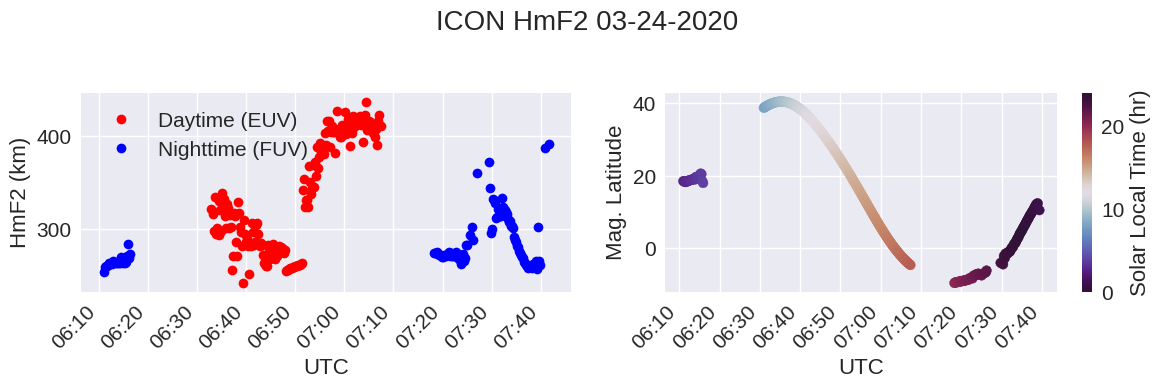

In [22]:
plt.close()

fig,ax=plt.subplots(figsize=(12,4))
fig.suptitle('ICON HmF2 %s' % ( show_time[0].strftime("%m-%d-%Y")),size=20,x=0.5)
gs = gridspec.GridSpec(1,2) 

ax0=plt.subplot(gs[0])
ax0.plot(select_dEUV['time'],select_dEUV['HmF2'],'ro',label='Daytime (EUV)')
ax0.plot(select_dL25['time'],np.nanmean(select_dL25['HmF2'],axis=1),'bo',label='Nighttime (FUV)')
ax0.set_xlabel('UTC')
ax0.set_ylabel('HmF2 (km)')
ax0.legend(fontsize=15)

ax0=plt.subplot(gs[1])
im=ax0.scatter(select_dEUV['time'],select_dEUV['tang_mlat'],c=select_dEUV['tang_slt'],vmax=24,vmin=0,cmap='twilight_shifted')
im=ax0.scatter(select_dL25['time'],select_dL25['HmF2_mlat'][:,3],c=select_dL25['tang_slt'][:,3],vmax=24,vmin=0,cmap='twilight_shifted')
ax0.set_ylabel('Mag. Latitude')
ax0.set_xlabel('UTC')
color_bar=fig.colorbar(im)
color_bar.set_label('Solar Local Time (hr)')

fig.autofmt_xdate(rotation=45)

plt.tight_layout(rect=[0, 0.0, 1.0, 0.95])
plt.show()

## Extension: Visualizing the in-situ IVM ion density and EUV O+ density profilt at tangent points

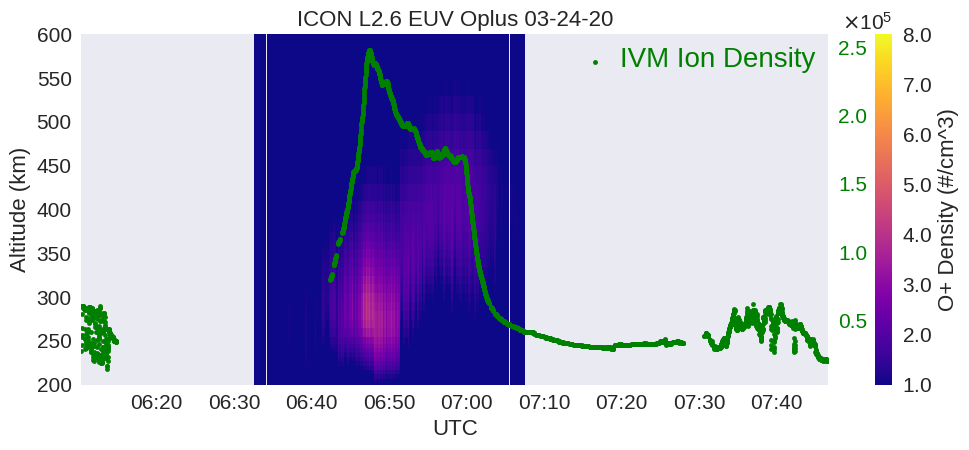

In [23]:
show_time=select_di['time']
### IVM Ion Density ####

target_2_array=select_di['Ni']
X_2_array=select_di['time']

## EUV Oplus ###
target_1_array=select_dEUV['Oplus']
X_1_array, Y_1_array = np.meshgrid(select_dEUV['time'],select_dEUV['tang_alt'][:,0])


cmap_1='plasma'
vmax_1=8*10**5
vmin_1=1*10**5
variable_name_1='ICON L2.6 EUV Oplus %s' % show_time[0].strftime("%m-%d-%y")
xlabel_1='UTC'
ylabel_1='Altitude (km)'
cb_label_1='O+ Density (#/cm^3)'

######################## PLOT #############################

fig,ax=plt.subplots(figsize=(10,5))#fig=pp.figure(figsize=(12,10)


gs = gridspec.GridSpec(1, 1) 

ax0=plt.subplot(gs[0,0])
im = ax0.pcolor(X_1_array,Y_1_array,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1, shading='auto')#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.set_ylim([200,600])
ax0.set_xlim([show_time[0],show_time[-1]])
ax0.set_title(variable_name_1)
ax0.set_xlabel(xlabel_1)
ax0.set_ylabel(ylabel_1)
color_bar=fig.colorbar(im,format=OOMFormatter(5, mathText=True))
color_bar.set_label(cb_label_1)

ax2 = ax0.twinx()
ax2.plot(X_2_array,target_2_array/100000.,'g.',label='IVM Ion Density')
ax2.grid(None)
leg=plt.legend(loc='best')
for text in leg.get_texts():
    plt.setp(text, color = 'g',size=20)
ax2.tick_params(axis='y', colors="g")
ax0.set_xlim([show_time[0],show_time[-1]])

myFmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])
plt.show()

# Example 3: IVM-MIGHTI  - Neutral wind driven electrodynamic interactions
- Once per orbit, ICON crosses the equator in the daytime.
- IVM measures the vertical drift at the equator
- MIGHTI measures the wind profile at the northern footpoint of the magnetic field line.


In [24]:
'''Find first equator crossing during daytime''' 
icon_near_equator = (abs(di['mlat']) < 1.) # ICON is within 2 degree of equator
daytime = abs(di['slt'] - 12) < 6 # ICON is in daytime hours
ii = np.where(icon_near_equator & daytime)
t0 = di['time'][ii]
print('ICON near equator starting at %s' % t0[0])
dm=dm_g

# Find MIGHTI index that matches this time
# Note: in practice, the true MIGHTI-IVM conjunction may happen a couple minutes before or after this time.
# Magnetic field line tracing is recommended to find true conjunctions.
# find_min is an array for the minimum time difference between each t0 and MIGHTI.
find_min=[(np.nanmin(abs((dm['time']-i)))) if not np.all(np.isnan(dm['uzon'][np.argmin(abs((dm['time']-i))),:])) else (np.nan) for i in t0]
# find_argmin is an array for the argument (index) of the minimum time difference between each t0 and MIGHTI.
find_argmin=[(np.argmin(abs((dm['time']-i)))) if not np.all(np.isnan(dm['uzon'][np.argmin(abs((dm['time']-i))),:])) else (np.nan) for i in t0]
# Transfer find_min (datetime.timedelta object) to a float array time_diff. 
time_diff=[(i.total_seconds()) if not pd.isnull(i) else (np.nan) for i in find_min]

m_idx=find_argmin[np.nanargmin(time_diff)]
i_idx=np.nanargmin(time_diff)

ICON near equator starting at 2020-03-24 00:34:24.284000


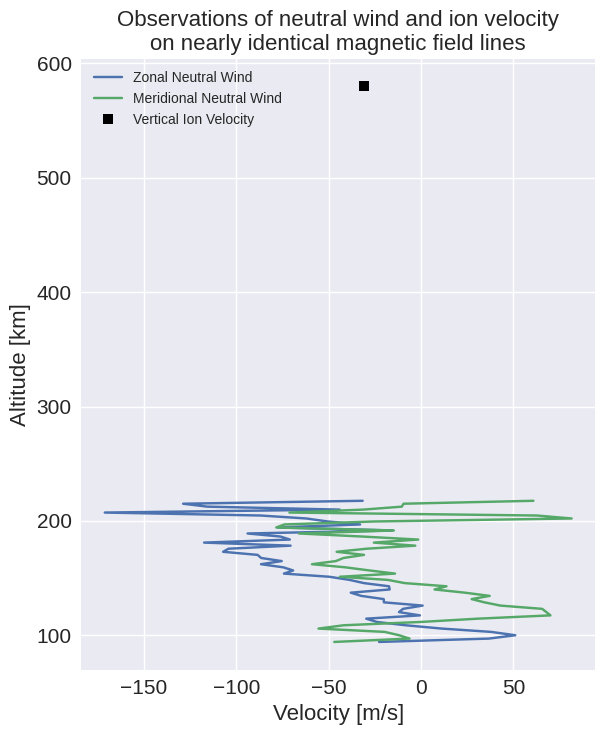

In [27]:

#### Plot the profiles ###
plt.close()
plt.figure(figsize=(6,8))

plt.plot(dm['uzon'][m_idx,:], dm['tang_alt'], 'C0-', label='Zonal Neutral Wind')
plt.plot(dm['umer'][m_idx,:], dm['tang_alt'], 'C1-', label='Meridional Neutral Wind')
plt.plot(di['vmer'][ii][i_idx], di['alt'][ii][i_idx], 'ks', label='Vertical Ion Velocity')
plt.ylabel('Altitude [km]')
plt.xlabel('Velocity [m/s]')
plt.title('Observations of neutral wind and ion velocity\non nearly identical magnetic field lines')
# plt.ylim([90,250])
plt.legend(loc='upper left')
plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])
plt.show()